## Transfer Learning
*This notebook is for creating a model to predict the crop diseases using transfer learning*

Steps to build our model.

1.   Image Preprocessing
      * Convert to array

2.   Image Augmentation using Keras Image Data Generator
3.   Model Building
      * Use Transfer Learning models like VGG16, Xception, MobileVNet, etc.

*Create a function that will allow us to run the model over and over again to check for optimal parameters*

Focal Loss code copied from https://medium.com/swlh/multi-class-classification-with-focal-loss-for-imbalanced-datasets-c478700e65f5

## Image Preprocessing

In [1]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator

In [2]:
def preprocess(image):
  img = cv2.GaussianBlur(image,(5,5),0)
  return img_to_array(img)

## Image Augmentation

In [3]:
# VARIABLES

TARGET_SIZE = (224, 224)
BATCH_SIZE = 50
EPOCHS = 40

LEARNING_RATE = 1e-4

In [4]:
train_path = '/content/drive/MyDrive/Omdena/Osun Nigeria/Data/Maize Images/data/train'
test_path = '/content/drive/MyDrive/Omdena/Osun Nigeria/Data/Maize Images/data/test'

In [5]:
train_generator = ImageDataGenerator(rescale=1.0/255,
                             rotation_range=30,
                             width_shift_range=0.3,
                             height_shift_range=0.3,
                             zoom_range=0.2,
                             shear_range=0.3,
                             horizontal_flip=True,
                             brightness_range=[0.2, 0.8],
                             validation_split=0.2,
                             preprocessing_function=preprocess)

valid_generator = ImageDataGenerator(rescale=1./255,
                                     validation_split = 0.2,
                                   preprocessing_function=preprocess)

test_generator = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=preprocess)

In [6]:
def augment_images(datagen, directory, batch_size, target_size, subset=None):
  augmented_imgs = datagen.flow_from_directory(directory = directory,
                                                    target_size = TARGET_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    subset = subset)
  return augmented_imgs

In [7]:
train_aug = augment_images(train_generator, train_path, BATCH_SIZE, TARGET_SIZE, 'training')
valid_aug = augment_images(valid_generator, train_path, BATCH_SIZE, TARGET_SIZE, 'validation')
test_aug = augment_images(test_generator, test_path, BATCH_SIZE, TARGET_SIZE)

Found 2681 images belonging to 4 classes.
Found 667 images belonging to 4 classes.
Found 840 images belonging to 4 classes.


## Model Specification

In [8]:
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [9]:
vgg_model = VGG16(input_shape=(224, 224, 3), weights="imagenet", include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [10]:
xception_model = Xception(input_shape=(224, 224, 3), weights="imagenet", include_top=False)

83697664/83683744 [==============================] - 1s 0us/step


In [11]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [12]:
def build_model(pretrained_model):

  for layer in pretrained_model.layers:
    layer.trainable = False

  model = Sequential()
  model.add(pretrained_model)

  #Adding our own classifier
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate = LEARNING_RATE), loss=focal_loss(alpha=1), metrics=['accuracy'])

  return model

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train_model(model, name):

  checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/Omdena/Osun Nigeria/Model/weights_{name}.hdf5', monitor='val_loss', save_best_only=True)

  stop = EarlyStopping(monitor="val_loss", patience=4)

  history = model.fit(train_aug,
                    steps_per_epoch=len(train_aug)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_aug,
                    verbose=2,
                    shuffle=True,
                    callbacks = [checkpoint])
  return history

In [14]:
xcep_hist = train_model(build_model(xception_model), 'xception_fc')

Epoch 1/40
1/1 - 370s - loss: 1.3171 - accuracy: 0.1600 - val_loss: 1.6015 - val_accuracy: 0.3208


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
1/1 - 31s - loss: 1.7921 - accuracy: 0.3800 - val_loss: 1.2171 - val_accuracy: 0.4798
Epoch 3/40
1/1 - 30s - loss: 1.7438 - accuracy: 0.3200 - val_loss: 1.6532 - val_accuracy: 0.3328
Epoch 4/40
1/1 - 30s - loss: 0.9432 - accuracy: 0.4400 - val_loss: 1.4896 - val_accuracy: 0.3553
Epoch 5/40
1/1 - 27s - loss: 1.5324 - accuracy: 0.3600 - val_loss: 0.8848 - val_accuracy: 0.5697
Epoch 6/40
1/1 - 28s - loss: 0.7871 - accuracy: 0.5600 - val_loss: 0.6567 - val_accuracy: 0.6222
Epoch 7/40
1/1 - 27s - loss: 0.8011 - accuracy: 0.6000 - val_loss: 0.3341 - val_accuracy: 0.6807
Epoch 8/40
1/1 - 24s - loss: 0.5756 - accuracy: 0.6000 - val_loss: 0.1870 - val_accuracy: 0.8471
Epoch 9/40
1/1 - 24s - loss: 0.8024 - accuracy: 0.4800 - val_loss: 0.2705 - val_accuracy: 0.7841
Epoch 10/40
1/1 - 23s - loss: 0.5361 - accuracy: 0.7000 - val_loss: 0.3480 - val_accuracy: 0.7766
Epoch 11/40
1/1 - 24s - loss: 0.7674 - accuracy: 0.6200 - val_loss: 0.3399 - val_accuracy: 0.7811
Epoch 12/40
1/1 - 23s - loss

In [20]:
import matplotlib.pyplot as plt

def plot_acc_loss(trained_model):
  train_acc = trained_model.history['accuracy']
  val_acc = trained_model.history['val_accuracy']
  train_loss = trained_model.history['loss']
  val_loss = trained_model.history['val_loss']

  plt.figure()
  plt.plot(train_acc)
  plt.plot(val_acc)
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train Accuracy', 'Validation Accuracy'], loc = 'lower right')
  plt.show()

  plt.figure()
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train Loss', 'Validation Loss'], loc = 'upper right')
  plt.show()

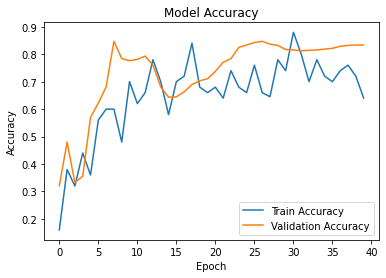

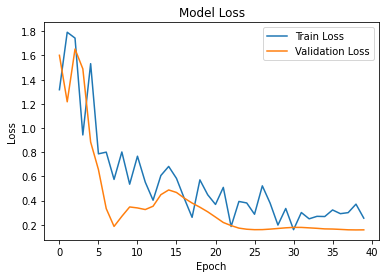

In [21]:
plot_acc_loss(xcep_hist)

In [24]:
# evaluate the model

acc = xcep_hist.model.evaluate(test_aug)
acc

17/17 [==============================] - 366s 23s/step - loss: 0.1487 - accuracy: 0.8405


[0.1486794650554657, 0.8404762148857117]

In [28]:
new_model = build_model(xception_model)
new_model.load_weights('/content/drive/MyDrive/Omdena/Osun Nigeria/Model/weights_xception_fc.hdf5')

predictions = new_model.predict(test_aug)
predictions[:5]

array([[0.21941839, 0.651176  , 0.12062262, 0.008783  ],
       [0.4278399 , 0.04122583, 0.33149505, 0.19943923],
       [0.03168522, 0.4980067 , 0.00884083, 0.4614672 ],
       [0.01577614, 0.9782924 , 0.00449149, 0.00144002],
       [0.02631811, 0.95624703, 0.00913124, 0.00830361]], dtype=float32)

In [29]:
test_labels = test_aug.classes
test_label_name = [cls for cls in test_aug.class_indices.keys()]

In [30]:
from sklearn.metrics import accuracy_score

score = accuracy_score(test_labels, predictions.argmax(axis=1))
score

0.2833333333333333

In [31]:
# import classification_report
from sklearn.metrics import classification_report


print(classification_report(test_labels, predictions.argmax(axis=1), target_names=test_label_name))

                precision    recall  f1-score   support

        Blight       0.27      0.32      0.29       230
   Common_Rust       0.32      0.34      0.33       262
Gray_Leaf_Spot       0.13      0.08      0.10       115
       Healthy       0.30      0.28      0.29       233

      accuracy                           0.28       840
     macro avg       0.26      0.26      0.25       840
  weighted avg       0.28      0.28      0.28       840



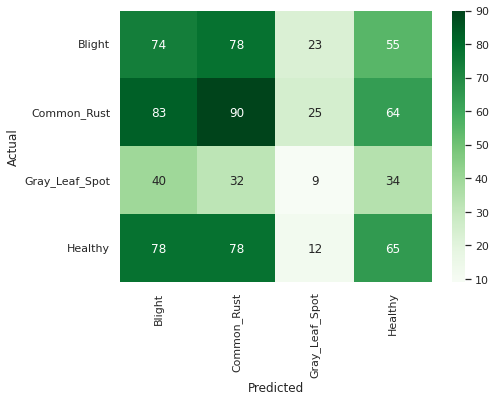

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


result = confusion_matrix(test_labels, predictions.argmax(axis=1))

result_df = pd.DataFrame(result, columns=test_label_name, index = test_label_name)
result_df.index.name = 'Actual'
result_df.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sns.set(font_scale=1)
sns.heatmap(result_df, cmap='Greens', annot=True,annot_kws={"size": 12})